In [1]:
import tclab
import numpy
import pandas

import tbcontrol
from tbcontrol import blocksim

import matplotlib.pyplot as plt
from latex_figure import plotfigure

# Parameter Functions

In [2]:
def cohen_coon(controller_type, parameters):
    K, tau, theta =  parameters
    
    if controller_type == 'P':
        Kc = (1.03/K)*(tau/theta + 0.34)
        return Kc

#PI controller
    if controller_type == 'PI':
        Kc = (0.9/K)*(tau/theta + 0.092)
        tauI = (3.33*theta)*((tau + 0.092*theta)/(tau + 2.22*theta))
        return Kc, tauI


#PD controller
    if controller_type == 'PD':
        Kc = (1.24/K)*(tau/theta + 0.129)
        taud = 0.27*theta*((tau - 0.324*theta)/(tau + 0.129*theta))
        α = 2
        return Kc, taud, α

#PID controller
    if controller_type == 'PID':
        Kc = (1.35/K)*(tau/theta + 0.185)
        tauI = 2.5*theta*((tau + 0.185*theta)/(tau + 0.611*theta))
        taud = 0.37*theta*(tau/(tau + 0.185*theta))
        return Kc, tauI, taud

In [3]:
def IAE_setpoints(controller_type, parameters):
    K, tau, theta = parameters
#setpoints
    if controller_type == 'PI':   
        # PI
        Kc = (0.758/K)*(theta/tau)**-0.861
        tauI = tau/(1.02 - 0.323*(theta/tau))
        return Kc, tauI


    if controller_type == 'PID':
        # PID
        Kc = (1.086/K)*(theta/tau)**-0.869
        tauI = tau/(0.740 - 0.130*(theta/tau))
        taud = 0.348*tau*(theta/tau)**0.914
        return Kc, tauI, taud

In [4]:
def IAE_disturbances(controller_type, parameters):
    K, tau , theta = parameters
#disturbance
    if controller_type == 'P':
        # P
        Kc = (0.902/K)*(theta/tau)**-0.985
        return Kc
    
    if controller_type == 'PI':
        # PI
        Kc = (0.984/K)*(theta/tau)**-0.986
        tauI = (tau/0.608)*(theta/tau)**0.707
        return Kc, tauI

    if controller_type == 'PID':
        # PID
        Kc = (1.435/K)*(theta/tau)**-0.921
        tauI = (tau/0.878)*(theta/tau)**0.749
        taud = 0.482*tau*(theta/tau)**1.137
        return Kc, tauI, taud

# Block Sim Creation

In [5]:
def controller_block(controller_type, parameters):
    
    if controller_type == 'P':
        Kc_P = parameters
        Gc_P = blocksim.LTI('Gc_P', 'e', 'Q', Kc_P, 1)
        return Gc_P
    
    if controller_type == 'PI':
        Kc_PI, tauI_PI = parameters
        Gc_PI = blocksim.PI('Gc_PI','e','Q', Kc_PI, tauI_PI)
        return Gc_PI
    
    if controller_type == 'PD':
        Kc_PD, tauD_PD, α = parameters
        Gc_PD = blocksim.LTI('Gc_PD','e','Q', [Kc_PD * tauD_PD * (α + 1), Kc_PD], [tauD_PD * α, 1]) 
        # Used the α term for physical realizability - Textbook eq 7-12 pg 129
        return Gc_PD
    
    if controller_type == 'PID':
        Kc_PID, tauI_PID, tauD_PID = parameters
        Gc_PID = blocksim.PID('Gc_PID', 'e', 'Q', Kc_PID, tauI_PID, tauD_PID)
        return Gc_PID

In [6]:
def system_block(parameters):
    K, tau, theta = parameters
    Gp = blocksim.LTI('Gp', 'Q', 'Tp', K, [tau, 1], theta) # Block of the system FOPDT model
    return Gp

# Params

In [7]:
K = 0.6423177737615754
tau = 150.3121523254063
theta = 17.396993066317368

In [8]:
params = [K, tau, theta]

In [9]:
controller_types = ['P', 'PI', 'PID']
IAE_Set = ['PI', 'PID']
IAE_Dis = ['P', 'PI', 'PID']
Names = ['CC P', 'CC PI', 'CC PID', 'IAE Setpoint PI', 'IAE Setpoint PID', 'IAE Distrurbance P', 'IAE Distrurbance PI', 'IAE Distrurbance PID']

In [10]:
integral_steps = 100

In [27]:
run_length = 1000

# Runs

In [28]:
Gp = system_block(params)

In [29]:
all_controller_blocks = []

for controller in controller_types:
    Gc = controller_block(controller, cohen_coon(controller, params))
    all_controller_blocks.append(Gc)

for controller in IAE_Set:
    Gc = controller_block(controller, IAE_setpoints(controller, params))
    all_controller_blocks.append(Gc)

for controller in IAE_Dis:
    Gc = controller_block(controller, IAE_disturbances(controller, params))
    all_controller_blocks.append(Gc)

In [30]:
all_controller_blocks

[LTI: e →[ Gc_P ]→ Q,
 PI: e →[ Gc_PI ]→ Q,
 PID: e →[ Gc_PID ]→ Q,
 PI: e →[ Gc_PI ]→ Q,
 PID: e →[ Gc_PID ]→ Q,
 LTI: e →[ Gc_P ]→ Q,
 PI: e →[ Gc_PI ]→ Q,
 PID: e →[ Gc_PID ]→ Q]

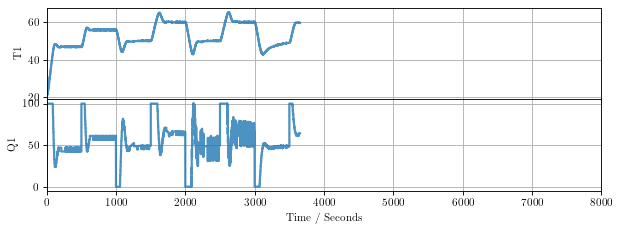

In [ ]:
TCLab = tclab.setup(connected=False, speedup=10)

with TCLab() as lab:
    sources = [('T1', lambda: lab.T1),
                ('Q1', lambda: lab.U1)]
    h = tclab.Historian(sources)
    p = tclab.Plotter(h, run_length*len(all_controller_blocks))
    
    
    for index, Gc in enumerate(all_controller_blocks):
        for t in tclab.clock(run_length):         
            
            if t < run_length/2:
                T1sp = 50
            else:
                T1sp = 60
                                
            Q1 = lab.Q1(Gc.output)
            T1 = lab.T1
            e = T1sp-T1
            
            print (Names[index], T1sp, t, T1)
            
            
            
            for step in range(integral_steps):
                Gc.change_input(t,e)
                Gc.change_state(Gc.state+Gc.derivative(e)/integral_steps)


            h.update(t + index*run_length) 
            p.update(t + index*run_length)

In [ ]:
h.get_sessions()

In [ ]:
h.load_session(1)

In [ ]:
data = {"Time" : h.t, "T1" : h.logdict['T1'], "T2" : h.logdict['T2'], "Q1" : h.logdict['Q1'], "Q2" : h.logdict['Q2']}

In [ ]:
data_frame = pandas.DataFrame(data = data)
data_frame.to_csv("Controller Testing.csv")